# Quantum Generative Adversarial Networks
In this notebook we will take a look at Quantum Generative Adversarial Networks (QGAN), the quantum counterpart of Generative Adversarial Networks (GANs); but what are GANs in the first place?. Before looking at the definition of GANs, it is worthwhile to mention the main difference between supervised machine learning models and generative models. In the first case, the model showcases its ability to make predictions on unseen data based on its training on a dataset by recognizing patterns between data points. Generative models work in a different way. Instead of trying to learn patterns between data points they aim at learning the underlying probability distribution which then enables them to generate new samples of data (following the initial real distribution). 
A particular class of these generative models is called GANs. In simple terms, a GAN is made up of two neural network, the generator and the discriminator.


# The generator 
The aim of the genearator is to produce data that resembles the real distribution in order to confuse the discriminator. With each step in training the generator becomes better and better at producing data that resembles the real distribution.
We would like the generator to be able to produce a wide range of data in the most non deterministic way possibile. One way to do so is to use a latent space, basically we feed the generator a random noise vector (usually sampled from a multivariate gaussian distribution). The generator gives a promising result when it shows that it can be able to map points from the latent space (mainly Gaussian noise) to the space of fake data samples that resemble the real distribition. We recall that, in the non degenarate case (i.e when the covariance matrix $\sum$ is not singular), the multivariate Gaussian probability distribution is of the form:
$$
f_{\vec{X}}(x_1,x_2\dots x_n) = \frac{1}{\sqrt{(2\pi)^n \det{\Sigma}}}\exp\left(-\frac{1}{2}(\vec{x}-\vec{\mu})^T\Sigma^{-1}(\vec{x}-\vec{\mu})\right)
$$
We say that a real random vector $\vec{X} = (X_1, X_2, \dots, X_n)$ is a standard vector if each entry is distributed according to a normal distribution of mean zero and standard deviation equal to one. In mathematical terms 
$$
X_i \sim \mathcal{N}(0,1) \quad  i = 1,2,\dots, n
$$

# The discriminator 
The dsicriminator takes as input data generated from the real distribution and from the generator, without knowing which is which. Its goal is to determine wheter data takes as input is real or fake.
The training of the model ends when the generator is capable of reproducing almost identically the data from the real distribution, leaving the discriminator no choice but to guess randonmly wheter the data presented is real or fake.

# Quantum Generative Adversarial Networks 
Around $2018$ Referece $1$ and $2$ proposed a quantum version of the GAN. The basic idea is to provide both the generator and discriminator (in the general case), with parametrized quantum circuit with the goal of optimizing the parameters to learn information from quantum and classical data.
Similiarly to what happens in the classical case, the objective of a full functioning QGAN is to reproduce, via the generator, a desired quantum state $\ket{\psi}$, feeding it to the discriminator which needs to assess wether the state is real or fake.
This process takes place in the following way.
The output of the generator is fed into the discriminator, which, trough a unitary $U_{D(\vec{\theta}_D)}$ acts on the input state. By using an additional qubit (which also goes trough this unitary) the classification consints in measuring the final state of the additional qubit. If the outcome is $\ket{0}$ then data is labelled as real, otherwise , if the outcome is $\ket{1}$ the data is labelled as real. 
The real data is ecoded into the circuit using the unitary $U_R$
$$
\ket{\text{Data}_R} = U_R\ket{0}^{\otimes n }
$$
which then is fed into the discriminator, giving the final state
$$ \ket{\text{Final}_R} = U_{D(\vec{\theta})}(\ket{\text{Data}_R}\otimes \ket{0})$$
where $\vec{\theta}_D$ is the vector containing the parameters which are usually optimized using a classical optimizer.
In the second case, a ficticious wave function is generated by the generator by the unitary $U_{G(\vec{\theta}_G)}$
$$
\ket{\text{Data}_G} = U_{G(\vec{\theta}_G)}\ket{0}^{\otimes n}
$$
Finally, taking the expectation value of the observable $I^{\otimes n}Z$ we get the classification we want. In fact, note that 
$$
\bra{\text{fake}}Z\ket{\text{fake}}= 1$$
which means that the discriminator thinks that the data fed as input is fully fake if the expectation value of $Z$ on the last qubit is $1$.
Since $\bra{0}Z\ket{0}=1$ the discriminator will assign $\ket{0}$ to fake samples and $\ket{1}$ to real ones, opposed to what happens to the generator. Using an adapted form of Reference $2$ in order to build the cost function we use the following rule 
$$
\min_{\vec{\theta}_G}\max_{\vec{\theta}_D}\bigg\{ \text{Pr}\left( D(\vec{\theta}_D,R) = \ket{\text{real}}\right)+ \text{Pr}\left( D(\vec{\theta}_D,G(\vec{\theta}_G)) = \ket{\text{fake}}\right) \bigg\} 
$$

We will now implement a QGAN that is able to learn the $2$ qubit Bell state
$$
\ket{\psi} = \frac{1}{\sqrt{2}}\left(\ket{00}+\ket{11}\right)
$$

In [603]:
import numpy as np
from qiskit import QuantumCircuit
import matplotlib.pyplot as plt
from qiskit.primitives import Estimator
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import TwoLocal
import tensorflow as tf
#from qiskit.utils import QuantumInstance
#from qiskit.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
import pickle
import scipy
from scipy.sparse import csr_matrix


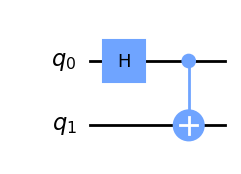

In [604]:
# first let's construct the entangles state 
n_real_qubits = 2                               # number of qubits needed to specify the real distribution
rc = QuantumCircuit(n_real_qubits)              # circuit that creates the state 
rc.h(0)
rc.cx(0,1)
rc.draw(output = "mpl", style = "clifford")

In [605]:
# check that the state is correct
sv = Statevector.from_instruction(rc)
sv.draw("latex")

<IPython.core.display.Latex object>

Here, we use the TwoLocal ansatze.

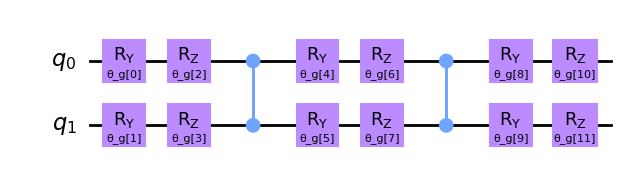

In [606]:
generator = TwoLocal(n_real_qubits,
                    # Parameterized single qubit rotations
                     ['ry', 'rz'],  'cz',  # Entangling gate
                     'full', # Entanglement structure: all to all
                     reps=2, # Number of layers
                     parameter_prefix='θ_g',
                     name='Generator')
generator = generator.decompose() 
generator.draw(output = "mpl", style = "clifford")

Variational quantum discrimimator, using $\vec{\theta}_D$ with dimension $12$.

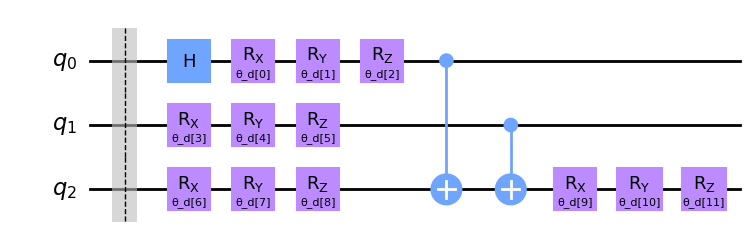

In [607]:
disc_weights = ParameterVector('θ_d', 12)
discriminator = QuantumCircuit(3, name="Discriminator")
discriminator.barrier()
discriminator.h(0)
discriminator.rx(disc_weights[0], 0)
discriminator.ry(disc_weights[1], 0)
discriminator.rz(disc_weights[2], 0)
discriminator.rx(disc_weights[3], 1)
discriminator.ry(disc_weights[4], 1)
discriminator.rz(disc_weights[5], 1)
discriminator.rx(disc_weights[6], 2)
discriminator.ry(disc_weights[7], 2)
discriminator.rz(disc_weights[8], 2)
discriminator.cx(0, 2)
discriminator.cx(1, 2)
discriminator.rx(disc_weights[9], 2)
discriminator.ry(disc_weights[10], 2)
discriminator.rz(disc_weights[11], 2)
discriminator.draw(output = "mpl", style = "clifford")

We can now make the $2$ circuits from the QGAN

In the first circuit, the discriminator takes as input the state generated from the generator, in this case the TwoLocalMap

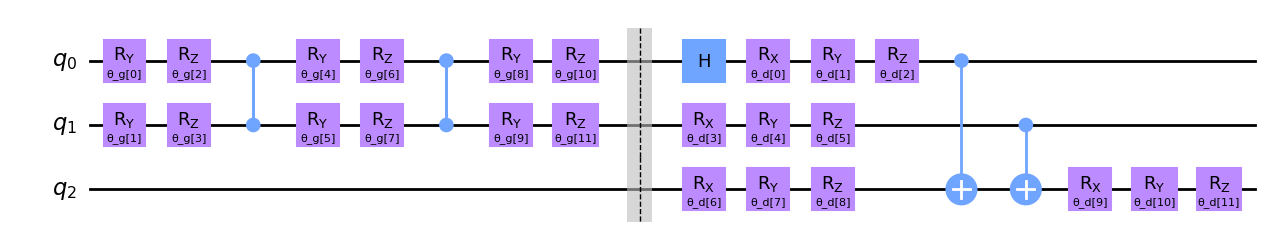

In [608]:
# compose the discriminator circuit that takes as input the state generated by the generator
n_gparams = generator.num_parameters
n_dparams = discriminator.num_parameters


# we need to add one qubit to the circuit used for the classification 
gen_disc_circuit = QuantumCircuit(n_real_qubits + 1)
gen_disc_circuit.compose(generator, inplace = True)
gen_disc_circuit.compose(discriminator, inplace = True)
gen_disc_circuit.draw(output = "mpl", style = "clifford")

In the second circuit the discriminator takes as input the real state, which is created by the circuit we have seen at the beginning.

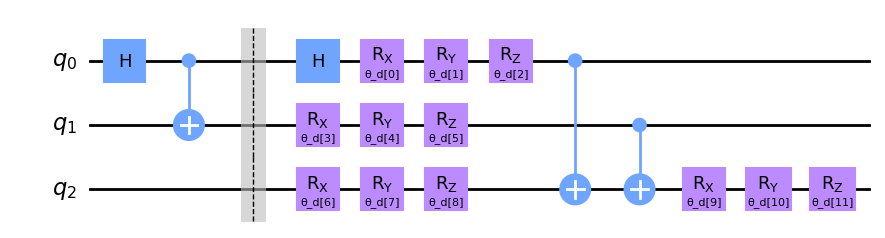

In [609]:
# compose the discriminator circuit that takes as input the real state 

real_disc_circuit = QuantumCircuit(n_real_qubits + 1)               # we still need one additional qubit to make the classification 
real_disc_circuit.compose(rc, inplace = True)
real_disc_circuit.compose(discriminator, inplace = True)
real_disc_circuit.draw(output = "mpl", style = "clifford")


Given the choice of the min max the discriminator cost funtion is given by
$$
\text{Cost}_{D} =   \Pr\left( D(\vec{\theta}_D, G(\vec{\theta}_G)) = \left| \text{real} \right\rangle \right) 
- \Pr\left( D(\vec{\theta}_D, R) = \left| \text{real} \right\rangle \right)
$$

Minimizing this cost fucntion is equivalent to maximising the probability of correclty recognizing real data and minimizing the probability to classify  the fake data. 
The cost of the generator will thus be the opposite of the cost of the discriminator neglecting the second terms, which does not affect the generator at all. We have 
$$
\text{Cost}_{G} = - \Pr\left( D(\vec{\theta}_D, G(\vec{\theta}_G)) = \left| \text{real} \right\rangle \right) 
$$

In [610]:
# we can now write the 2 cost function, and obtain the state produced by the circuit with StateVector 

def cost_generator(gen_params):
    """
    Defines the cost function to be optimesed for the generator. Takes as input the parameter of the generator 
    """
    current_params  = np.append(disc_params.numpy(), gen_params.numpy())
    state_probs = Statevector(gen_disc_circuit.assign_parameters(current_params) ).probabilities()

    # compute the probability 
    prob_fake_true = np.sum(state_probs[0b100:])
    cost = - prob_fake_true
    return cost

def cost_discriminator(disc_params):
    """
    Defines the cost function to be optimesed for the discriminator. Takes as input the parameter of the discriminator 
    """
    current_params = np.append(disc_params.numpy(), gen_params.numpy())
    gen_probability = Statevector(gen_disc_circuit.assign_parameters(current_params)).probabilities()
    real_probabilty = Statevector(real_disc_circuit.assign_parameters(disc_params.numpy())).probabilities()

    # compute the total probability of finding |1> in q2
    prob_fake_true = np.sum(gen_probability[0b100:])
    prob_real_true = np.sum(real_probabilty[0b100:])
    cost = prob_fake_true - prob_real_true
    return cost 

In [611]:
# it is now helpful to define a function that computes the  Kullback-Leibler divergence between the model and target distribution
def calculate_kl_div(model_distribution: dict, target_distribution: dict):
    """Gauge model performance using Kullback Leibler Divergence"""
    kl_div = 0
    for bitstring, p_data in target_distribution.items():
        if np.isclose(p_data, 0, atol=1e-8):
            continue
        if bitstring in model_distribution.keys():
            kl_div += (p_data * np.log(p_data)
                 - p_data * np.log(model_distribution[bitstring]))
        else:
            kl_div += p_data * np.log(p_data) - p_data * np.log(1e-6)
    return kl_div

We now use the EstimatorQNN method to compile the ciruit and handles all the calculations.

In [612]:
# Initialize the new Estimator primitive
estimator = Estimator()

# specify QNN to update generator weights
gen_qnn = EstimatorQNN(
    circuit = gen_disc_circuit,
    input_params = gen_disc_circuit.parameters[:n_dparams],  # frozen (discriminator weights)
    weight_params = gen_disc_circuit.parameters[n_dparams:],  # trainable (generator weights)
    estimator = estimator
)

# specify QNNs to update discriminator weights (with fake data)
disc_fake_qnn = EstimatorQNN(
    circuit = gen_disc_circuit,
    input_params = gen_disc_circuit.parameters[n_dparams:],  # frozen (generator weights)
    weight_params  =gen_disc_circuit.parameters[:n_dparams],  # trainable (discriminator weights)
    estimator = estimator
)

# specify QNNs to update discriminator weights (with real data)
disc_real_qnn = EstimatorQNN(
    circuit = real_disc_circuit,
    input_params = [],  # no input parameters
    weight_params = gen_disc_circuit.parameters[:n_dparams],  # trainable (discriminator weights)
    estimator = estimator
)

/var/folders/hb/_vnjt6s167vgsfsr3dc6zm4w0000gn/T/ipykernel_19258/3550840366.py:5: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  gen_qnn = EstimatorQNN(
/var/folders/hb/_vnjt6s167vgsfsr3dc6zm4w0000gn/T/ipykernel_19258/3550840366.py:13: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  disc_fake_qnn = EstimatorQNN(
/var/folders/hb/_vnjt6s167vgsfsr3dc6zm4w0000gn/T/ipykernel_19258/3550840366.py:21: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  disc_real_qnn = EstimatorQNN(


In [613]:
# in order to optimize the parameters, we use the adam optimizer 
# Initialize parameters
init_gen_params = np.random.uniform(low = -np.pi, high = np.pi, size = (n_gparams,))
init_disc_params = np.random.uniform(low = -np.pi, high = np.pi, size = (n_dparams,))

gen_params = tf.Variable(init_gen_params)
disc_params = tf.Variable(init_disc_params)

# in order to go back to the previous variables, one can use .numpy() on the new tf variables used in the omptimizer

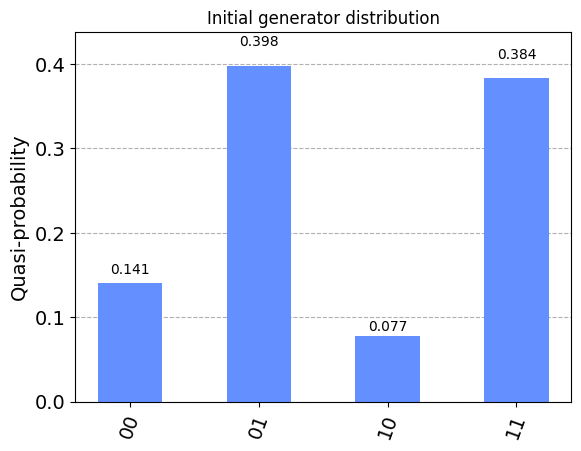

In [614]:
# we can initialise the generator circuit 
init_gen_circuit = generator.assign_parameters(init_gen_params)

# we can extract the probabilities looking at the state produced by the circuit
init_prob_dict = Statevector(init_gen_circuit).probabilities_dict()

# plot the corresponding probabilities
fig, ax1 = plt.subplots(1, 1, sharey=True)
ax1.set_title("Initial generator distribution")
plot_histogram(init_prob_dict, ax=ax1)
plt.show()

In [615]:
# we ca now start with the optimization procedure for both the generator and the discriminator 

generator_optimizer  = tf.keras.optimizers.Adam(learning_rate = 0.02)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.02)

# here we set the same learning rate for the 2 optimizers 


In [616]:
# Initialize variables to track metrics while training
best_gen_params = tf.Variable(init_gen_params)
gloss = []
dloss = []
kl_div = []

In [617]:
# d_real = disc_real_qnn.backward([], disc_params)[1]                    # returns a multidimensional array 
# #d_real = d_real.flatten()                                              # turn it into a 1 dimensional array 
# d_real_trimmed = d_real[0, 0, 4:]
# print(d_real_trimmed)
# d_real_matrix = d_real_trimmed.reshape((2,4))
# print(d_real_matrix)
# d_real_matrix = np.sum(d_real_matrix, axis = 0)
# print(d_real_matrix)

In [618]:
d_real = disc_real_qnn.backward([], disc_params)[1][0]     
print(np.sum(d_real, axis = 0))             


[ 1.87438929e-01 -4.05349025e-02  1.38777878e-17 -5.65745979e-02
 -9.57343489e-02 -1.11022302e-16  2.37488319e-01  6.84917018e-01
 -5.17312773e-01 -2.56940373e-01  8.43577120e-01 -2.77555756e-17]


In [619]:
print(gen_params)
print(disc_params)

<tf.Variable 'Variable:0' shape=(12,) dtype=float64, numpy=
array([ 1.96241413,  0.60773064, -2.17631811,  1.62721931, -1.06322275,
       -1.0694494 , -2.82179419, -2.57056445,  0.3774045 , -1.02748262,
        2.77096489, -1.89452447])>
<tf.Variable 'Variable:0' shape=(12,) dtype=float64, numpy=
array([ 2.47931301, -2.63769539,  0.19586029,  3.14042968, -1.86409493,
       -2.30276254, -0.59404119,  0.37242361,  2.83529267,  2.12202749,
        0.92276743,  2.22287583])>


In [620]:
TABLE_HEADERS = "Epoch | Generator cost | Discriminator cost | KL Div. |"
print(TABLE_HEADERS)
for epoch in range(100):
    """ We repeat the training process for 100 epochs"""

    # first update the parameters for the quantum generator
    discriminator_steps = 5
    for step in range(discriminator_steps):
        # take the gradient with respect to the weights 
        d_fake = disc_fake_qnn.backward(gen_params, disc_params)[1][0]

        d_fake = np.sum(d_fake, axis = 0)           

        # do the same for the real parameters 

        d_real = disc_real_qnn.backward([], disc_params)[1][0]

        d_real = np.sum(d_real, axis = 0)               

        # cost function for the discriminator 
        #grad_disc_cost = [d_fake_array[i]-d_real_array[i] for i in range(n_dparams)]
        grad_disc_cost = [d_fake[i]-d_real[i] for i in range(n_dparams)]
        grad_dcost = tf.convert_to_tensor(grad_disc_cost)                      # convert to tf variable 

        # update the discriminator parameters with the gradient 
        discriminator_optimizer.apply_gradients(zip([grad_dcost], [disc_params]))

        # keep track of the discrminator loss function over each iteration
        if step % discriminator_steps == 0:
            dloss.append(cost_discriminator(disc_params))


    # do the same for the parameters of the generator 
    for gen_train_step in range(1):
        # compute the gradients with respect to the weights
        
        grads = gen_qnn.backward(disc_params, gen_params)[1]                        # returns a multidimensional array 

        grads = grads.flatten()                                                     # turn in into a 1 dimensional array 
        
        # cost function for the generator 

        grads = - grads
        grads = tf.convert_to_tensor(grads)                                         # convert it to tf variable 
        # Update gen params with gradient
        generator_optimizer.apply_gradients(zip([grads], [gen_params]))
        gloss.append(cost_discriminator(gen_params))



 #--- Track KL and save best performing generator weights ---#
    # Create test circuit with updated gen parameters

    gen_checkpoint_circuit = generator.assign_parameters(gen_params.numpy())
    # Retrieve probability distribution of current generator

    gen_prob_dict = Statevector(gen_checkpoint_circuit).probabilities_dict()
    
    # Constant real probability distribution
    real_prob_dict = Statevector(rc).probabilities_dict()
    current_kl = calculate_kl_div(gen_prob_dict, real_prob_dict)
    kl_div.append(current_kl)
    if np.min(kl_div) == current_kl:
        # New best
        # serialize & deserialize to simply ensure zero links
        best_gen_params = pickle.loads(pickle.dumps(gen_params))
    if epoch % 10 == 0:
        # print table every 10 epochs
        for header, val in zip(TABLE_HEADERS.split('|'),(epoch, gloss[-1], dloss[-1], kl_div[-1])):
            print(f"{val:.3g} ".rjust(len(header)), end="|")
        print()


Epoch | Generator cost | Discriminator cost | KL Div. |
    0 |       -0.00146 |             -0.114 |   0.724 |
   10 |        0.00461 |            0.00198 |   0.391 |
   20 |       -0.00855 |           2.75e-05 |   0.172 |
   30 |        -0.0431 |           1.85e-07 |  0.0324 |
   40 |          0.112 |           9.31e-08 |  0.0223 |
   50 |         0.0351 |           1.45e-09 | 0.00678 |
   60 |        -0.0601 |           1.11e-08 |  0.0071 |
   70 |        -0.0357 |           3.79e-10 |  0.0203 |
   80 |          0.113 |          -4.12e-12 |  0.0123 |
   90 |          0.146 |          -4.37e-12 |   0.063 |


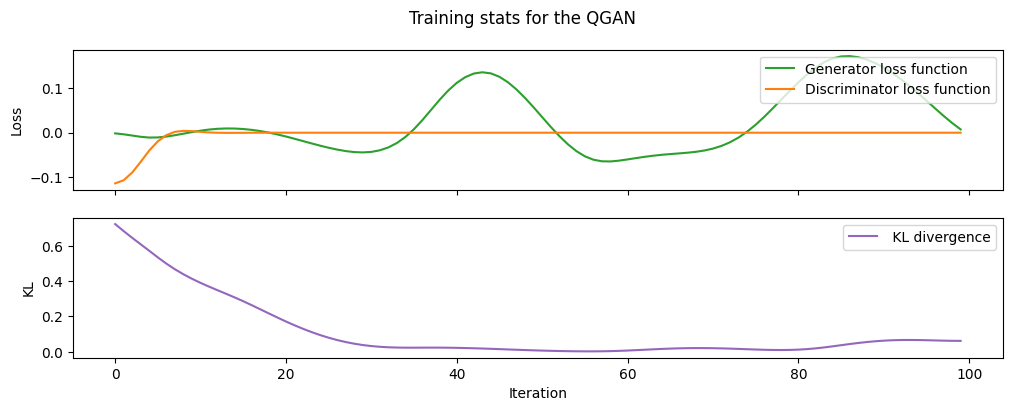

In [621]:
# plot the result of the training in terms of the loss functions and KL divergence 
fig, ax = plt.subplots(2, 1, sharex = True, figsize = (12,4))
fig.suptitle(r'Training stats for the QGAN')

iterations = np.arange(0, len(gloss))

ax[0].plot(iterations, gloss, label = r'Generator loss function', c = 'C2')
ax[0].plot(iterations, dloss, label = r'Discriminator loss function', c = 'C1')
ax[1].plot(iterations, kl_div, label = r' KL divergence', c = 'C4')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel(r'KL')
ax[0].set_ylabel(r'Loss')
ax[0].legend(loc = 'upper right')
ax[1].legend(loc = 'upper right')

plt.show()

Text(0.5, 1.0, 'Real distribution')

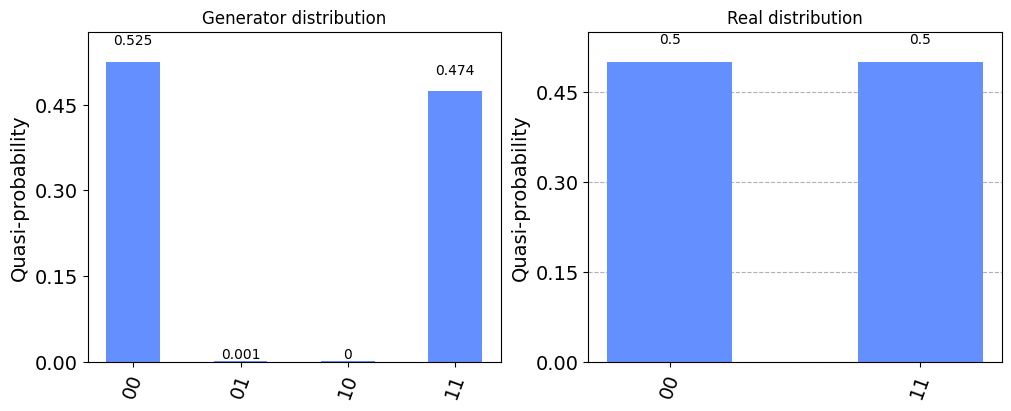

In [622]:
# we can now create the circuit with the parameters from the training 
gen_checkpoint_circuit = generator.assign_parameters(best_gen_params.numpy())

# get the probability distribution from the state vector generated by the generator circuit 
gen_prob_dict = Statevector(gen_checkpoint_circuit).probabilities_dict()

# get the probability distribution from the state generated by the real circuit
real_prob_dict = Statevector(rc).probabilities_dict() 

# plot the results 

fig, ax, = plt.subplots(1, 2, figsize = [10,4], constrained_layout = True)
plot_histogram(gen_prob_dict, ax = ax[0])
plot_histogram(real_prob_dict, ax = ax[1])
ax[0].set_title(r'Generator distribution')
ax[1].set_title(r'Real distribution')



We can now analyse the results we have obtained from training the QGAN. We see that, evene with just $100$ epochs the generator is capable of reproducing the Bell state 
$$
\ket{\psi} =\frac{1}{\sqrt{2}}\left(\ket{00}+\ket{11}\right)
$$
quite well.
Another point to be noted is that results may vary from simulation to simulation due to the nature of the QGAN. In certain runs it may be that one can obtain null gradients due to the fact that the discriminator makes accurate predictions.

# Another implementation of the QGAN 
We will now take a look at another example. We use the QGAN to learn a normal distribution generated by $3$ qubits. The main structures of the scheme remains the same, we will change few details in the process.

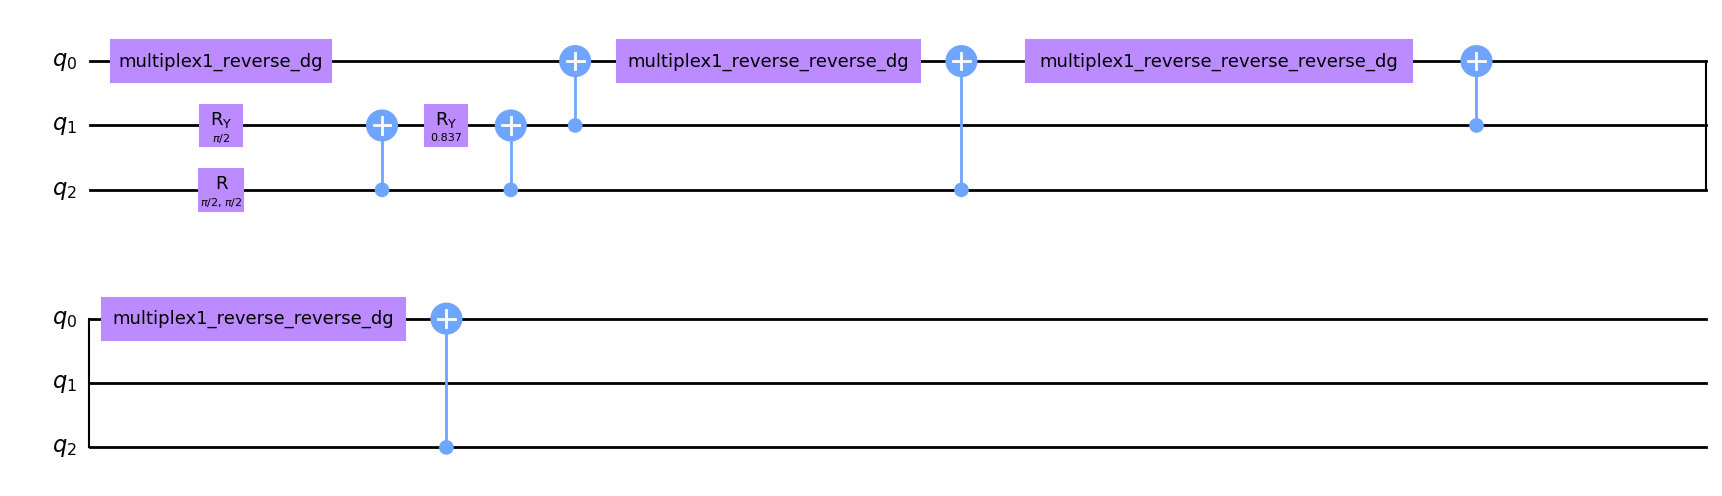

In [623]:
# here we will use the following library which we wills use to create the desired distribution 
from qiskit_finance.circuit.library import NormalDistribution

n_real_qubits = 3                                                       # we will use 3 qubits 
rc = NormalDistribution(num_qubits = 3, mu = 0, sigma = 0.15)           

# implements a circuit that creates a 3 qubit sate whose distribution is a Gaussian with mean zero and standard deviation 0.15
rc.decompose().decompose().decompose().draw(output = "mpl", style = "clifford")

In [624]:
# print the state created by the system 
state_created  = Statevector.from_instruction(rc)
display(state_created.draw("latex"))

<IPython.core.display.Latex object>

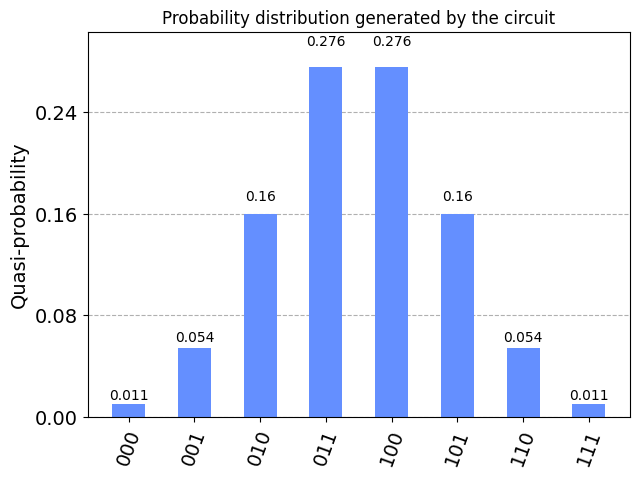

In [625]:
# plot the probability distribution and check that it is a gaussian with mean 0 and sigma 0.15

prob_dist = state_created.probabilities_dict()                                              # get the distribution from the state 
plot_histogram(prob_dist, title = r'Probability distribution generated by the circuit')

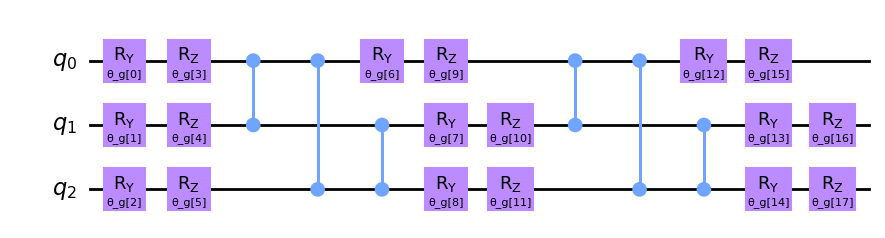

In [626]:
# we use the same quantum generator as before

generator = TwoLocal(num_qubits = 3, 
                     rotation_blocks = ['ry', 'rz'],             # parametrized rotation on single qubit
                     entanglement_blocks = 'cz',                 # entangling gate 
                     entanglement = 'full',
                     reps = 2,                                   # number of layers 
                     parameter_prefix='θ_g',
                     name='Generator'     
)

generator = generator.decompose()
generator.draw(output = "mpl", style = "clifford")

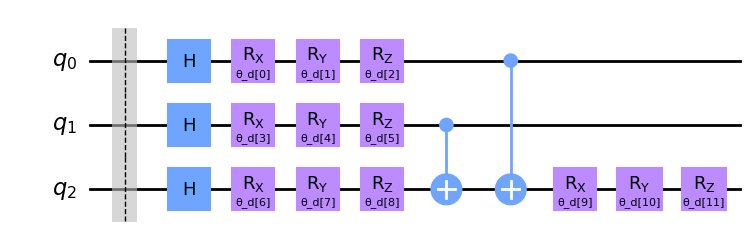

In [627]:
# for the discriminitaor we use a similiar circuit as the one we have used before 
# we move the measurment from q3 to q2 which does not change the classification based upon the expectation value of Z 

disc_weights = ParameterVector('θ_d', 12)
discriminator = QuantumCircuit(n_real_qubits, name = "Discriminator")
discriminator.barrier()
discriminator.h(0)
discriminator.rx(disc_weights[0], 0)
discriminator.ry(disc_weights[1], 0)
discriminator.rz(disc_weights[2], 0)
discriminator.h(1)
discriminator.rx(disc_weights[3], 1)
discriminator.ry(disc_weights[4], 1)
discriminator.rz(disc_weights[5], 1)
discriminator.h(2)
discriminator.rx(disc_weights[6], 2)
discriminator.ry(disc_weights[7], 2)
discriminator.rz(disc_weights[8], 2)
discriminator.cx(1,2)
discriminator.cx(0,2)
discriminator.rx(disc_weights[9], 2)
discriminator.ry(disc_weights[10], 2)
discriminator.rz(disc_weights[11], 2)
discriminator.draw(output = "mpl", style = "clifford")

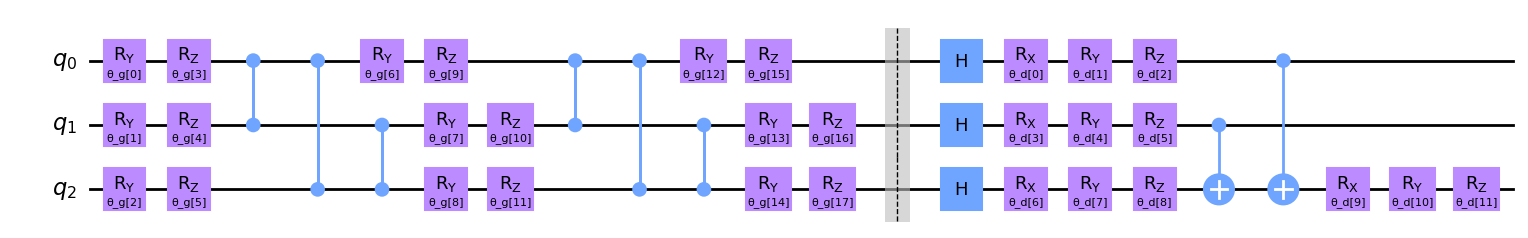

In [628]:
# number of total parameters 
n_gparams = generator.num_parameters
n_dparams = discriminator.num_parameters

# compile the whole circuit with the generator and discriminator 

generator_discriminator_circuit  = QuantumCircuit(n_real_qubits)
generator_discriminator_circuit.compose(generator, inplace = True)
generator_discriminator_circuit.compose(discriminator, inplace = True)
generator_discriminator_circuit.draw(output = "mpl", style = "clifford")

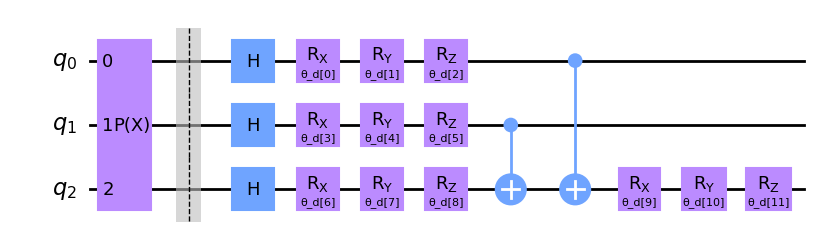

In [629]:
# do the same for the real circuit and the discriminator 
real_discriminator_circuit = QuantumCircuit(n_real_qubits)
real_discriminator_circuit.compose(rc, inplace = True)
real_discriminator_circuit.compose(discriminator, inplace = True)
real_discriminator_circuit.draw(output = "mpl", style = "clifford")


In [630]:
#from qiskit import Aer
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN

In [631]:
parameters_generator_discriminator = list(generator_discriminator_circuit.parameters)
parameters_real_discriminator = list(real_discriminator_circuit.parameters)

# Create dummy values for each parameter
parameters_gd_values = np.random.uniform(-1, 1, size=len(parameters_generator_discriminator)).tolist()
parameters_rd_values = np.random.uniform(-1, 1, size=len(parameters_real_discriminator)).tolist()
observable = SparsePauliOp.from_list([("ZII", 1.0)])
# Run estimator
gendisc_result = estimator.run(
    circuits = [generator_discriminator_circuit],
    observables = [observable],
    parameter_values = parameters_gd_values
).result()

redisc_result = estimator.run(
    circuits = [real_discriminator_circuit],
    observables = [observable],
    parameter_values = [parameters_rd_values]
).result()

# Get the expectation values
gendisc_expval = gendisc_result.values[0]
realdisc_expval = redisc_result.values[0]

In [632]:
# Generatior QNN (the generator wants to minimize this value)

gen_qnn = EstimatorQNN(
    circuit = generator_discriminator_circuit,
    input_params = generator_discriminator_circuit.parameters[:n_dparams],    # discriminator weights treated as inputs
    weight_params = generator_discriminator_circuit.parameters[n_dparams:],    # generator weights are trainable
    estimator = estimator
)

# Discriminator QNN (on fake data) — disc wants to maximize this
disc_fake_qnn = EstimatorQNN(
    circuit = generator_discriminator_circuit,
    input_params = generator_discriminator_circuit.parameters[n_dparams:],     # generator weights treated as inputs
    weight_params = generator_discriminator_circuit.parameters[:n_dparams],   # discriminator weights are trainable
    estimator = estimator
)

# Discriminator QNN (on real data)
disc_real_qnn = EstimatorQNN(
    circuit = real_discriminator_circuit,
    #input_params = [],  # no input parameters
    weight_params = generator_discriminator_circuit.parameters[:n_dparams],  # trainable (discriminator weights)
    estimator = estimator
)

/var/folders/hb/_vnjt6s167vgsfsr3dc6zm4w0000gn/T/ipykernel_19258/990525198.py:3: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  gen_qnn = EstimatorQNN(
/var/folders/hb/_vnjt6s167vgsfsr3dc6zm4w0000gn/T/ipykernel_19258/990525198.py:11: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  disc_fake_qnn = EstimatorQNN(
/var/folders/hb/_vnjt6s167vgsfsr3dc6zm4w0000gn/T/ipykernel_19258/990525198.py:19: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  disc_real_qnn = EstimatorQNN(


In [633]:
### START
init_gen_params = tf.Variable(np.random.uniform(low = -np.pi, high = np.pi,size = (n_gparams)))
init_disc_params = tf.Variable(np.random.uniform(low = -np.pi, high=np.pi , size = (n_dparams)))
gen_params = init_gen_params
disc_params = init_disc_params
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.02)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.02)

In [634]:
print(gen_params)
print(disc_params)

<tf.Variable 'Variable:0' shape=(18,) dtype=float64, numpy=
array([ 2.36528928,  0.95749442, -2.47213331,  0.56439758, -1.39796517,
        2.14947121,  2.39458624,  0.17865788,  2.85705619, -1.4064058 ,
       -0.70711772,  0.59728871,  0.64212111,  1.87754245,  1.69204095,
       -0.38416346,  2.63149814,  1.34126926])>
<tf.Variable 'Variable:0' shape=(12,) dtype=float64, numpy=
array([ 1.35787112,  0.60398175,  1.76432459, -1.34258234, -0.30392241,
        1.69309842, -1.6685684 , -0.19910819,  2.11000667,  1.12692475,
        1.78240744, -2.9567978 ])>


In [635]:
# grad_dcost_fake = disc_fake_qnn.backward(gen_params,disc_params)[1]
# print(grad_dcost_fake)
# grad_dcost_real = disc_real_qnn.backward([],disc_params)[1]
# print(grad_dcost_real)
# grad_dcost_fake = grad_dcost_fake.flatten()
# grad_dcost_real = grad_dcost_real.flatten()
# grad_dcost = grad_dcost_real - grad_dcost_fake # as above
# grad_dcost = tf.convert_to_tensor(grad_dcost)
#        # update disc_params
# discriminator_optimizer.apply_gradients(zip([grad_dcost],
#                                                     [disc_params]))



In [636]:
grad_gcost = gen_qnn.backward(disc_params,gen_params)
grad_dcost = np.array(grad_dcost)
print(grad_dcost) 

[-2.86571634e-02 -6.37852444e-02  1.38777878e-17 -6.18262916e-02
  1.09207263e-01 -8.32667268e-17  9.73357673e-06 -2.49014053e-04
  1.72399722e-04 -5.55111512e-17 -4.66678085e-12 -4.16333634e-17]


In [637]:
def cost_generator(gen_params):
    """
    Cost function for the generator. Takes generator parameters as input.
    """
    current_params = np.append(disc_params.numpy(), gen_params.numpy())
    param_dict = dict(zip(gen_disc_circuit.parameters, current_params))
    
    state_probs = Statevector(gen_disc_circuit.assign_parameters(param_dict)).probabilities()
    prob_fake_true = np.sum(state_probs[0b100:])  # q2 == |1>
    cost = -prob_fake_true
    return cost

def cost_discriminator(disc_params):
    """
    Cost function for the discriminator. Takes discriminator parameters as input.
    """
    # Assign parameters for the generator-discriminator (fake data)
    current_params = np.append(disc_params.numpy(), gen_params.numpy())
    param_dict_fake = dict(zip(gen_disc_circuit.parameters, current_params))
    gen_probability = Statevector(gen_disc_circuit.assign_parameters(param_dict_fake)).probabilities()

    # Assign parameters for the real-discriminator circuit
    param_dict_real = dict(zip(real_disc_circuit.parameters, disc_params.numpy()))
    real_probabilty = Statevector(real_disc_circuit.assign_parameters(param_dict_real)).probabilities()

    # Compute probabilities of output qubit q2 being in state |1>
    prob_fake_true = np.sum(gen_probability[0b100:])
    prob_real_true = np.sum(real_probabilty[0b100:])

    cost = prob_fake_true - prob_real_true
    return cost

In [638]:
grad_gcost = gen_qnn.backward(disc_params,gen_params)[1]
grad_gcost = tf.convert_to_tensor(grad_gcost)
print(grad_gcost)

tf.Tensor(
[[[ 0.12278349  0.12380025 -0.11621154  0.19917938  0.04498727
    0.06146698 -0.20573356 -0.00852027 -0.27218785 -0.08706514
    0.10542975 -0.01009121 -0.149456    0.09042141  0.21500694
    0.02903343  0.1396165   0.02576003]]], shape=(1, 1, 18), dtype=float64)


In [639]:
best_gen_params = init_gen_params
gloss, dloss, kl_div = [], [], []
TABLE_HEADERS = "Epoch | Gen. cost | Discrim. cost | KL Div | New best? |"
print(TABLE_HEADERS)
for epoch in range(300):
    D_STEPS = 5
    for disc_train_step in range(D_STEPS):
        grad_dcost_fake = disc_fake_qnn.backward(gen_params,disc_params)[1]          # returns a multidimensional array 
        grad_dcost_fake = grad_dcost_fake.flatten()                                  # turn it into a 1 dimensional array 

        grad_dcost_real = disc_real_qnn.backward([],disc_params)[1]
        grad_dcost_real = grad_dcost_real.flatten()  


        grad_dcost = grad_dcost_real - grad_dcost_fake # as above
        grad_dcost = tf.convert_to_tensor(grad_dcost)   

        if disc_train_step % D_STEPS == 0:
            dloss.append(cost_discriminator(disc_params))

     #--- Quantum generator parameter update ---#
    for gen_train_step in range(1):

        # grad_gcost = gen_qnn.backward(disc_params,gen_params)[1]
        # grad_gcost = tf.convert_to_tensor(grad_gcost)
        # # update gen_params
        # generator_optimizer.apply_gradients(zip([grad_gcost], [gen_params]))
        # gloss.append(cost_generator(gen_params))

        grad_gcost = gen_qnn.backward(disc_params, gen_params)[1]  # shape (1,1,18)

        # flatten and remove batch dimensions
        grad_gcost = tf.reshape(grad_gcost, [-1])  # shape (18,)
        grad_gcost = tf.convert_to_tensor(grad_gcost)

        # update gen_params
        generator_optimizer.apply_gradients([(grad_gcost, gen_params)])
        gloss.append(cost_generator(gen_params))
    
        #--- Track KL and save best performing generator weights ---#
    # Create test circuit with updated gen parameters
    gen_checkpoint_circuit = generator.assign_parameters(gen_params.numpy())
    # Retrieve probability distribution of current generator
    gen_prob_dict = Statevector(gen_checkpoint_circuit
                               ).probabilities_dict()
    # Constant real probability distribution
    real_prob_dict = Statevector(rc).probabilities_dict()
    current_kl = calculate_kl_div(gen_prob_dict, real_prob_dict)
    kl_div.append(current_kl)
    new_best = (np.min(kl_div) == current_kl)
    if new_best:
        # Store new best generator weights
        # serialize & deserialize to just zero links
        best_gen_params = pickle.loads(pickle.dumps(gen_params))
    if epoch % 30 == 0:
        # print table
        for header, val in zip(TABLE_HEADERS.split('|'),
                              (epoch, gloss[-1], dloss[-1],
                               kl_div[-1], new_best)):
            print(f"{val:.3g} ".rjust(len(header)), end="|")
        print()


Epoch | Gen. cost | Discrim. cost | KL Div | New best? |
    0 |   -0.0894 |        -0.033 |   0.87 |         1 |
   30 |     -0.12 |      0.000803 |  0.595 |         0 |
   60 |     -0.11 |      -0.00891 |  0.655 |         0 |
   90 |    -0.108 |       -0.0112 |  0.626 |         0 |
  120 |    -0.108 |       -0.0113 |  0.619 |         0 |
  150 |    -0.108 |       -0.0112 |  0.621 |         0 |
  180 |    -0.108 |       -0.0112 |  0.621 |         0 |
  210 |    -0.108 |       -0.0112 |  0.621 |         0 |
  240 |    -0.108 |       -0.0112 |  0.621 |         0 |
  270 |    -0.108 |       -0.0112 |  0.621 |         0 |


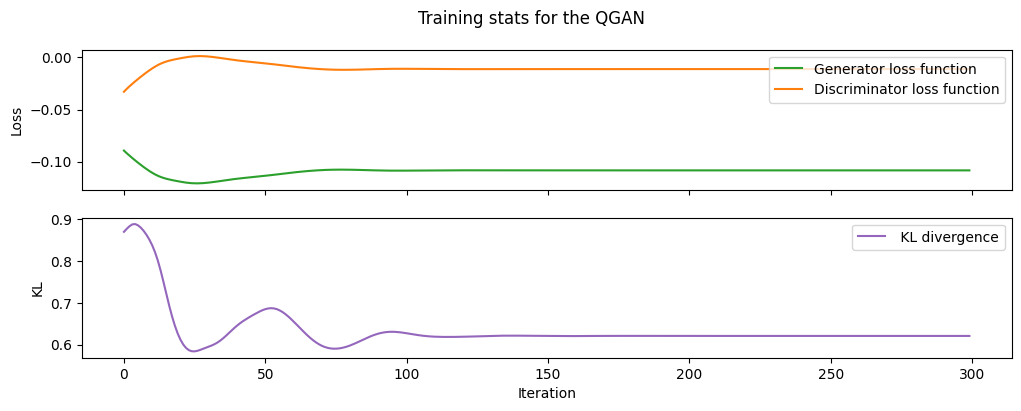

In [640]:
# plot the result of the training in terms of the loss functions and KL divergence 
fig, ax = plt.subplots(2, 1, sharex = True, figsize = (12,4))
fig.suptitle(r'Training stats for the QGAN')

iterations = np.arange(0, len(gloss))

ax[0].plot(iterations, gloss, label = r'Generator loss function', c = 'C2')
ax[0].plot(iterations, dloss, label = r'Discriminator loss function', c = 'C1')
ax[1].plot(iterations, kl_div, label = r' KL divergence', c = 'C4')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel(r'KL')
ax[0].set_ylabel(r'Loss')
ax[0].legend(loc = 'upper right')
ax[1].legend(loc = 'upper right')

plt.show()

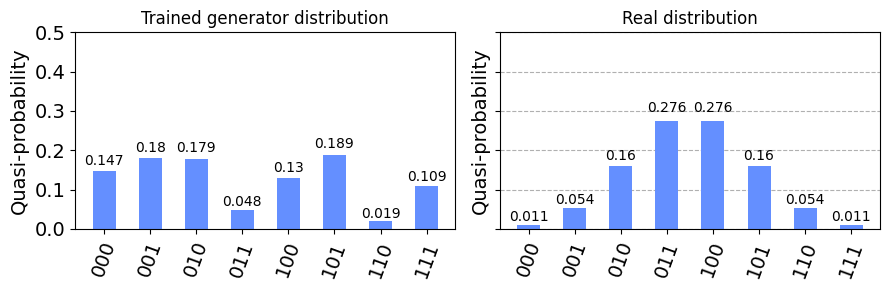

In [642]:
# Create test circuit with new parameters
gen_checkpoint_circuit = generator.assign_parameters(best_gen_params.numpy())
gen_prob_dict = Statevector(gen_checkpoint_circuit).probabilities_dict()
real_prob_dict = Statevector(rc).probabilities_dict() # constant
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(9,3))
plot_histogram(gen_prob_dict, ax=ax1)
ax1.set_title("Trained generator distribution")
plot_histogram(real_prob_dict, ax=ax2)
ax2.set_title("Real distribution")
ax2.set_ylim([0,.5])
fig.tight_layout()